In [9]:
## import libraries
import sys
import glob
import re

import cartopy
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import cmocean.cm as cmo
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar


# cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from plotter import draw_basemap, plot_terrain
from utils import roundPartial, select_months_ds
import customcmaps as ccmap

pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## Load tARgetv4 AR data
fname = path_to_data + 'downloads/globalARcatalog_ERA5_1940-2023_v4.0.nc'
ds = xr.open_dataset(fname)
ds = ds.isel(lev=0, ens=0)
ds = ds.assign_coords({"lon": (((ds.lon + 180) % 360) - 180)}) # Convert DataArray longitude coordinates from 0-359 to -180-179
latmin, latmax, lonmin, lonmax = 50., 75., -170., -129.
ds = ds.sel(lat=slice(latmax, latmin), lon=slice(lonmin, lonmax))
# ds = ds.sel(time=slice('2000-01-01', '2023-12-31'))

ds

<xarray.Dataset>
Dimensions:      (lon: 165, lat: 101, time: 122724)
Coordinates:
  * lon          (lon) float64 -170.0 -169.8 -169.5 ... -129.5 -129.2 -129.0
  * lat          (lat) float64 75.0 74.75 74.5 74.25 ... 50.75 50.5 50.25 50.0
    lev          float64 0.0
  * time         (time) datetime64[ns] 1940-01-01 ... 2023-12-31T18:00:00
    ens          float64 1.0
Data variables: (12/55)
    islnd        (lat, lon) float32 ...
    iscst        (lat, lon) float32 ...
    ivt_begin    (lat, lon) float64 ...
    ivt_end      (lat, lon) float64 ...
    shapemap     (time, lat, lon) float32 ...
    axismap      (time, lat, lon) float64 ...
    ...           ...
    kinstveldir  (time, lat) float32 ...
    axisidx      (time, lat, lon) float32 ...
    axislon      (time, lat, lon) float32 ...
    axislat      (time, lat, lon) float32 ...
    numobj       (time, lat, lon) float32 ...
    intblosto    (lat, lon) float64 ...
Attributes:
    title:                 Global Atmospheric River Database
    version:               2024.03.30
    creation_date:         30-Mar-2024 13:15:27
    tARget_version:        1.312
    dimension_convention:  5-d (nlon x nlat x nlev x ntime x nens) variables ...
    references:            (1) Guan, B., and D. E. Waliser (2015), Detection ...

In [5]:
%%time
tARget_new = xr.where((ds['kidmap'] > 0.), 1, 0)
## sum/count the values divide by total
count_tARgetv4 = (tARget_new.sum(dim="time") / ds.time.shape ) *100
count_tARgetv4 = count_tARgetv4.compute()

CPU times: user 2.89 s, sys: 1.34 s, total: 4.23 s
Wall time: 4.25 s


In [10]:
# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

# Set tick/grid locations
ext1 = [-168, -129.0, 50., 75] # extent of AK
dx = np.arange(ext1[0],ext1[1]+5,5)
dy = np.arange(ext1[2]-.5,ext1[3]+5,5)
lbl_lst = ['tARgetv4 (1940-2023)']

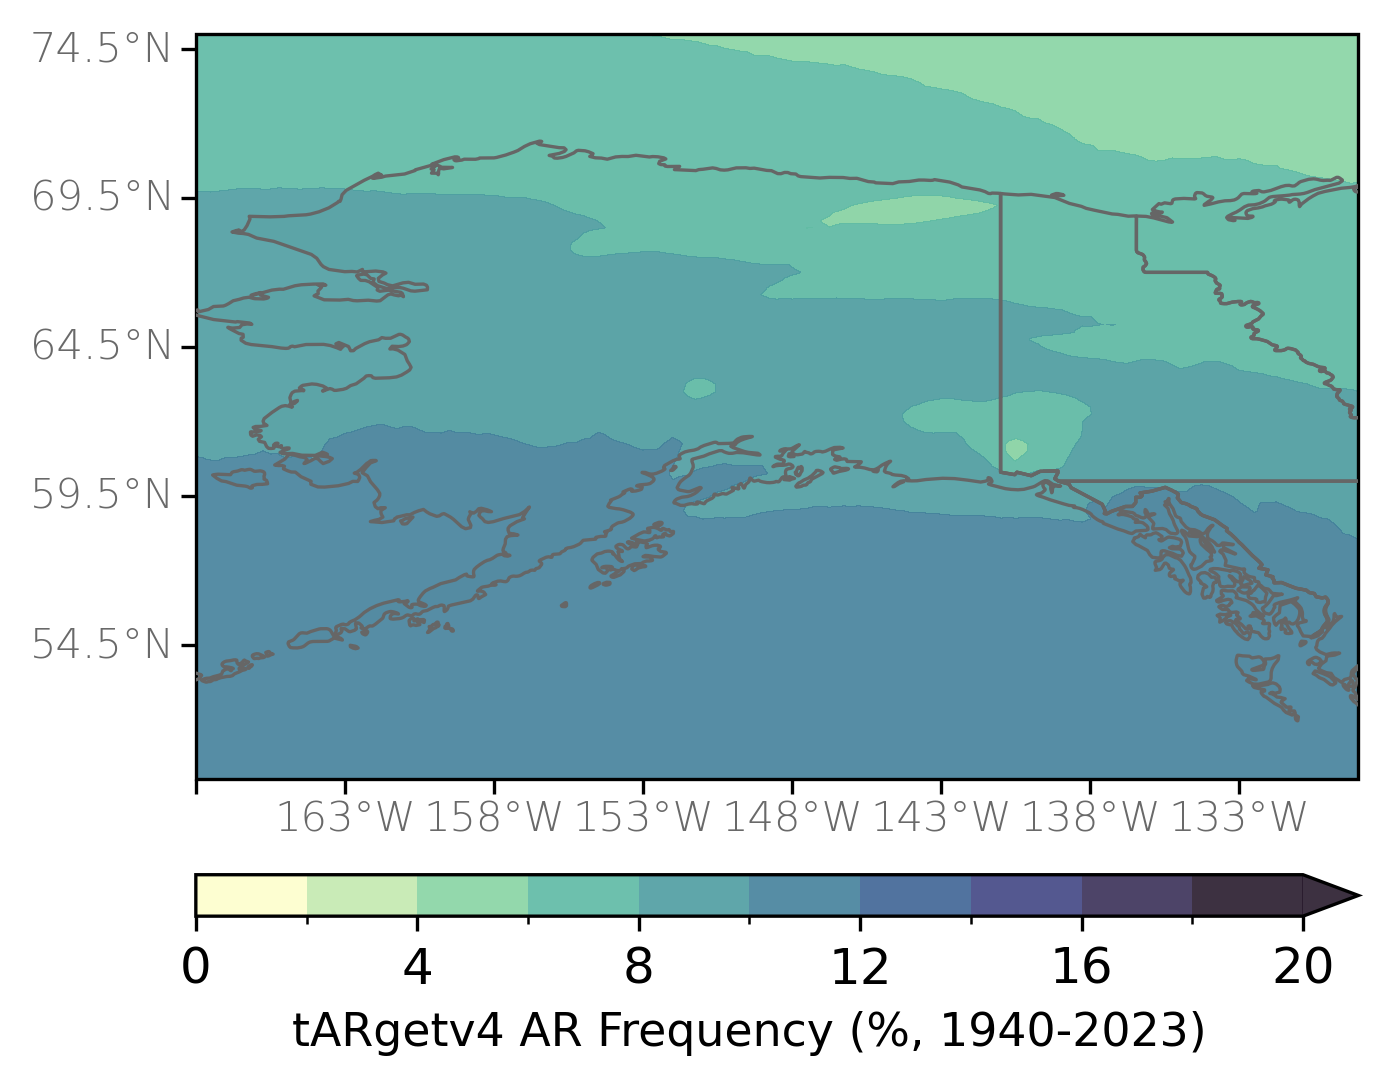

In [20]:
# Create figure
fig = plt.figure(figsize=(5, 4))
fig.dpi = 300
fname = path_to_figs + 'ar_freq_overhead_AK'
fmt = 'png'

nrows = 3
ncols = 1

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 0.05, 0.05], width_ratios = [1], wspace=0.02, hspace=0.02)
## use gs[rows index, columns index] to access grids

row_idx = [0]
b_lons = [True]
data_lst = [count_tARgetv4]
for k, data in enumerate(data_lst):
    ## Add axis for plot
    ax = fig.add_subplot(gs[row_idx[k],0], projection=mapcrs)
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy,left_lats=True, right_lats=False, bottom_lons=b_lons[k], mask_ocean=False, coastline=False)

    ## topo with gray shading
    # cs = plot_terrain(ax, ext1)

    # add choropleth watershed fraction
    cmap, norm, bnds = ccmap.cmap_segmented(cmo.deep, np.arange(0, 22, 2))
    cf = ax.contourf(data.lon.values, data.lat.values, data.values, transform=datacrs,
                     levels=bnds, cmap=cmap, norm=norm, alpha=0.9, extend='max')

    ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8, zorder=199)
    # ax.set_title('tARgetv4 AR Frequency (%) | (1940-2023)')

# Add color bar
cbax = plt.subplot(gs[-1,0]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom')
cb.set_label('tARgetv4 AR Frequency (%, 1940-2023)', fontsize=11)
cb.ax.tick_params(labelsize=12)
        
fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()